# Real Estate Price Prediction Model

### Data Set Includes data set of the city named Ames, State:Iowa, USA 


Dataset Link: https://www.kaggle.com/datasets/marcopale/housing/data

In [0]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import rand
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, sum

## Data Exploration

### Table Name - Train Data

In [0]:
sqlContext = SQLContext(sc)

/databricks/spark/python/pyspark/sql/context.py:117: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [0]:
train_df = sqlContext.sql("Select * from train")

In [0]:
train_df.show(5)

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

In [0]:
# Exploring the schema type of the data. Assuming there could be an errror in this, I have changed the data accordingly and converted few variables for instance LotFrontage which should be an integer and not a string.
train_df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

In [0]:
# Casting the numeric columns to the proper integer datatype
train_df = train_df.withColumn("LotFrontage", col("LotFrontage").cast("int"))
train_df = train_df.withColumn("MasVnrArea", col("MasVnrArea").cast("int"))
train_df = train_df.withColumn("GarageYrBlt", col("GarageYrBlt").cast("int"))
train_df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

In [0]:
# Shape of the Train Data Set
print("Total Number of rows: ", train_df.count())
print("Total Number of columns: ", len(train_df.columns))

Total Number of rows:  1460
Total Number of columns:  81


### Data Visualization - Train Data

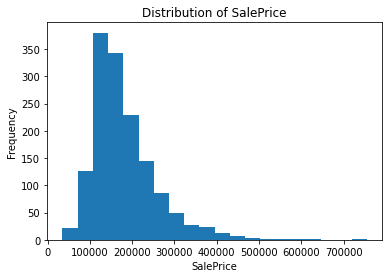

In [0]:
# Create a histogram of the Sale Price column
histogram_data = train_df.select('SalePrice').rdd.flatMap(lambda x: x).histogram(20)

# Get the histogram bin edges and counts
bin_edges = histogram_data[0]
bin_counts = histogram_data[1]

# Create a bar chart using Matplotlib
plt.bar(bin_edges[:-1], bin_counts, width=(bin_edges[1]-bin_edges[0]), align='edge')

# Add labels and title to the chart
plt.xlabel('SalePrice')
plt.ylabel('Frequency')
plt.title('Distribution of SalePrice')

# Display the chart
display(plt.show())

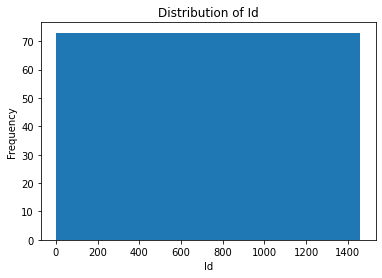

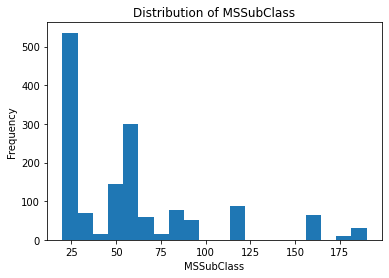

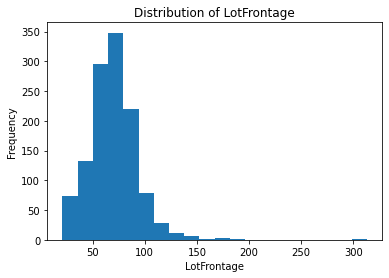

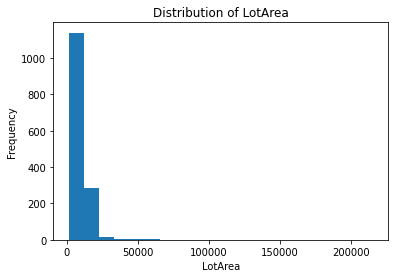

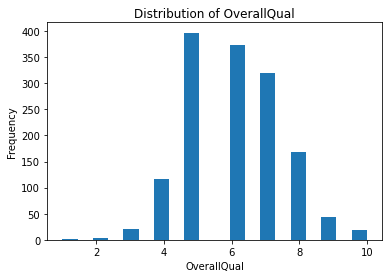

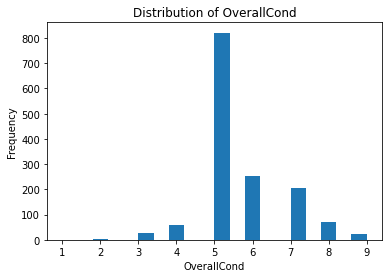

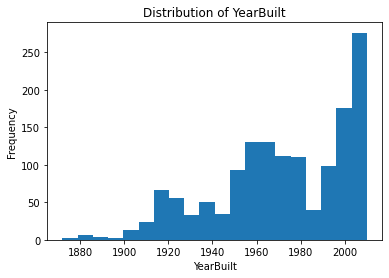

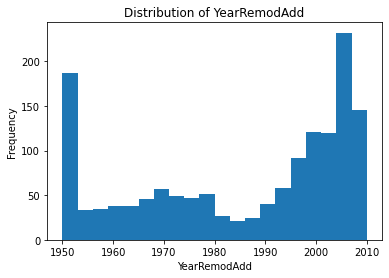

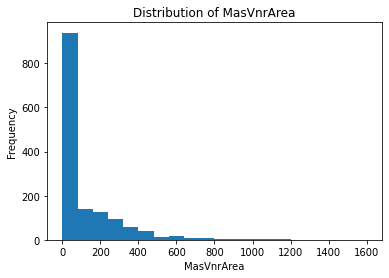

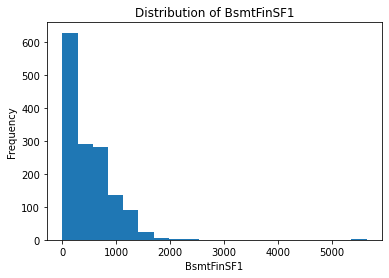

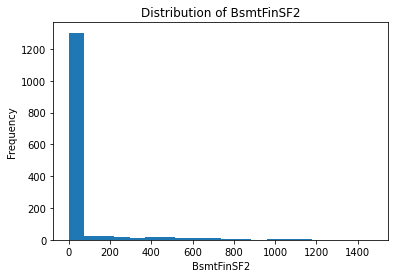

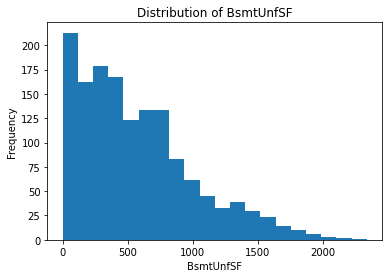

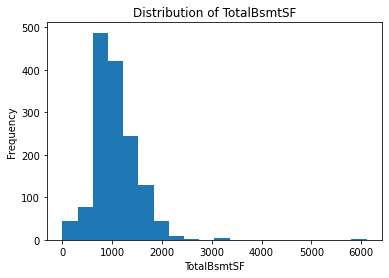

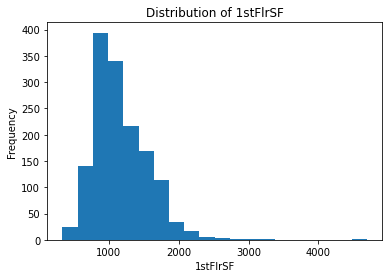

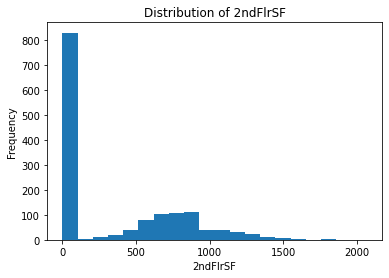

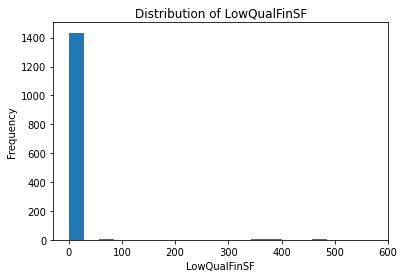

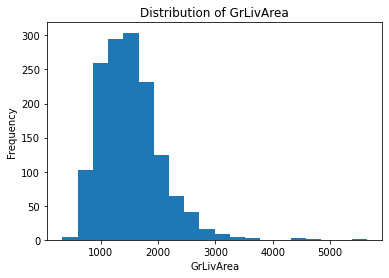

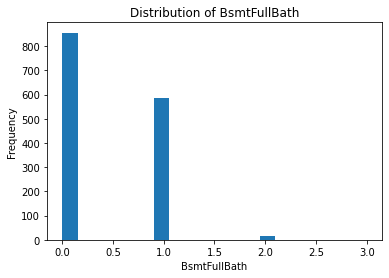

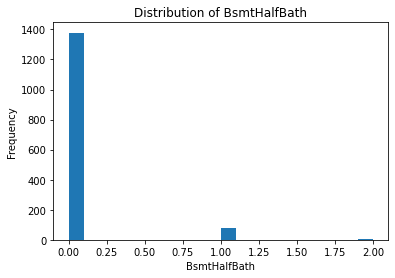

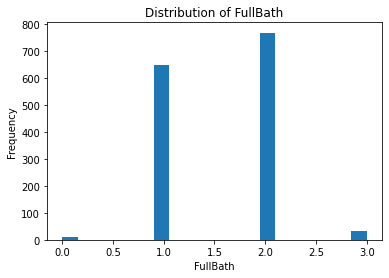

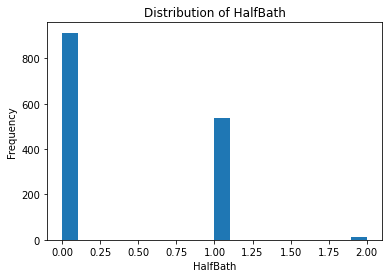

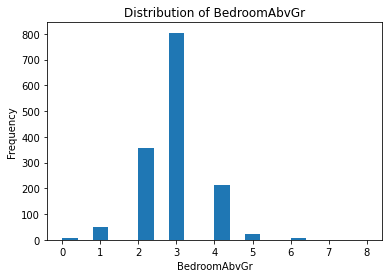

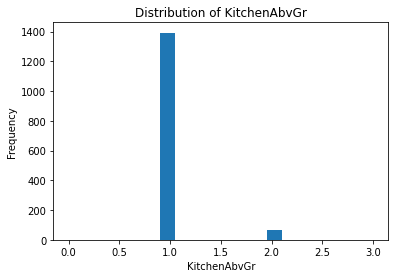

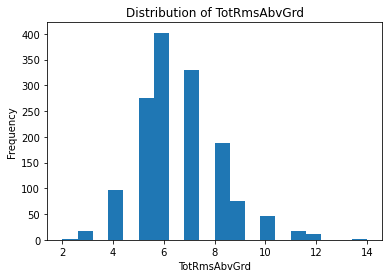

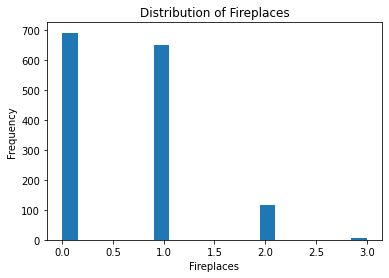

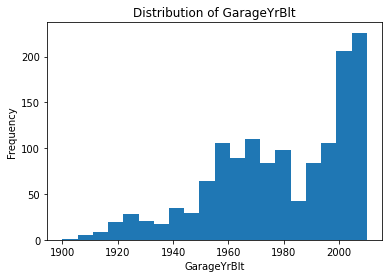

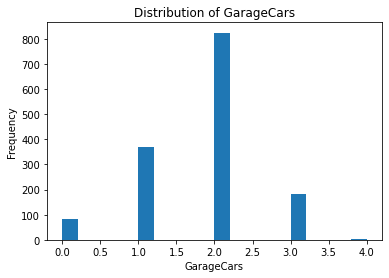

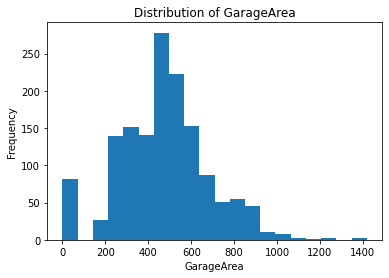

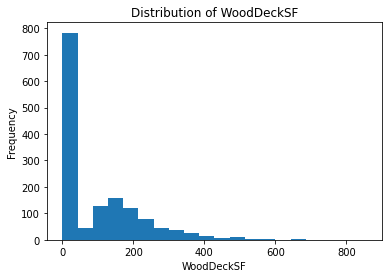

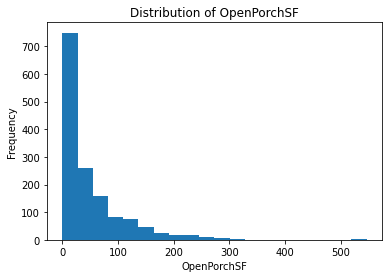

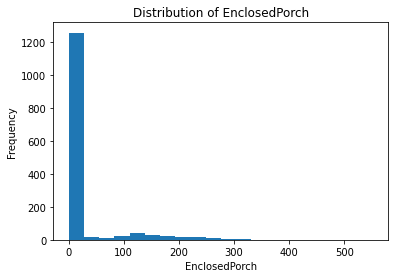

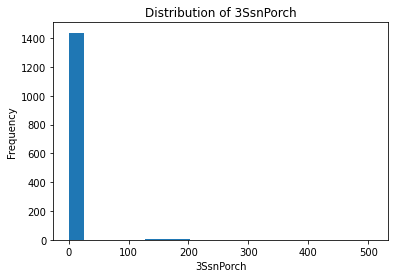

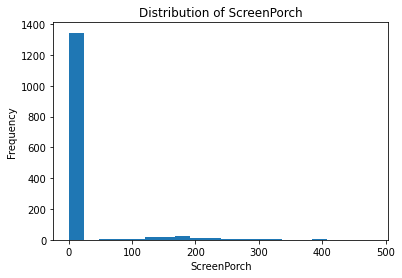

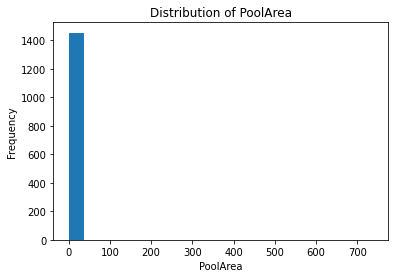

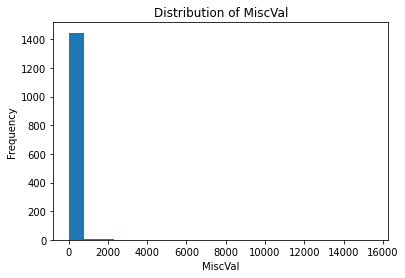

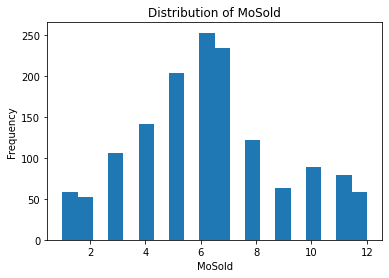

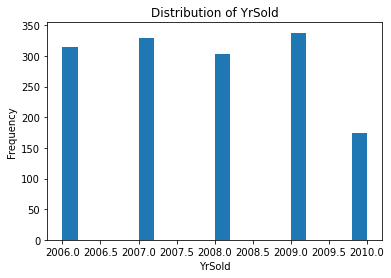

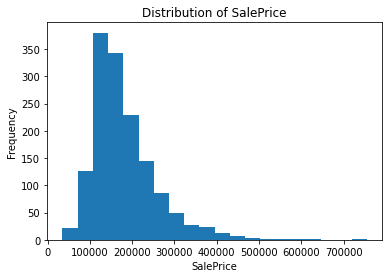

In [0]:
# We can view histograms for all numeric columns 

# Get the list of numeric column names
numeric_columns = [c[0] for c in train_df.dtypes if c[1].startswith('int') or c[1].startswith('float')]

# Plot a histogram for each numeric column
for column in numeric_columns:
    # Create a histogram of the column values
    histogram_data = train_df.select(column).rdd.flatMap(lambda x: x).histogram(20)

    # Get the histogram bin edges and counts
    bin_edges = histogram_data[0]
    bin_counts = histogram_data[1]

    # Create a bar chart using Matplotlib
    plt.bar(bin_edges[:-1], bin_counts, width=(bin_edges[1]-bin_edges[0]), align='edge')

    # Add labels and title to the chart
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {column}')

    # Display the chart
    display(plt.show())

Statistical Analysis for SalePrice

In [0]:
train_df.select('SalePrice').describe().show()

+-------+------------------+
|summary|         SalePrice|
+-------+------------------+
|  count|              1460|
|   mean|180921.19589041095|
| stddev| 79442.50288288663|
|    min|             34900|
|    max|            755000|
+-------+------------------+



In [0]:
train_df.stat.corr('SalePrice', 'LotArea')

Out[79]: 0.2638433538714051

### Table Name - Test Data

In [0]:
test_df = sqlContext.sql("Select * from test")

In [0]:
# Exploring the schema type of the data. Assuming there could be an errror in this, I have changed the data accordingly and converted few variables.
test_df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: string (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |--

In [0]:
# Casting the numeric columns to the proper integer datatype
test_df = test_df.withColumn("LotFrontage", col("LotFrontage").cast("int"))
test_df = test_df.withColumn("MasVnrArea", col("MasVnrArea").cast("int"))
test_df = test_df.withColumn("GarageYrBlt", col("GarageYrBlt").cast("int"))
test_df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

In [0]:
# Shape of the Test Data Set
print("Number of rows: ", test_df.count())
print("Number of columns: ", len(test_df.columns))

Number of rows:  1459
Number of columns:  80


In [0]:
# Compare the Train and Test data set to ensure that each column has the correct data type

def compare_data_types(df1, df2):
    matching_cols = []
    non_matching_cols = []
    
    for c1, t1 in df1.dtypes:
        for c2, t2 in df2.dtypes:
            if c1 == c2 and t1 == t2:
                matching_cols.append(c1)
                break
        else:
            non_matching_cols.append(c1)
    
    print("Matching columns:", matching_cols)
    print("Non-matching columns:", non_matching_cols)

In [0]:
compare_data_types(train_df, test_df)

Matching columns: ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
Non-matching

In [0]:
# Casting the numeric columns to the proper integer datatype
test_df = test_df.withColumn("BsmtFinSF1", col("BsmtFinSF1").cast("int"))
test_df = test_df.withColumn("BsmtFinSF2", col("BsmtFinSF2").cast("int"))
test_df = test_df.withColumn("BsmtUnfSF", col("BsmtUnfSF").cast("int"))
test_df = test_df.withColumn("TotalBsmtSF", col("TotalBsmtSF").cast("int"))
test_df = test_df.withColumn("BsmtFullBath", col("BsmtFullBath").cast("int"))
test_df = test_df.withColumn("BsmtHalfBath", col("BsmtHalfBath").cast("int"))
test_df = test_df.withColumn("GarageCars", col("GarageCars").cast("int"))
test_df = test_df.withColumn("GarageArea", col("GarageArea").cast("int"))
test_df.printSchema()

root
 |-- Id: integer (nullable = true)
 |-- MSSubClass: integer (nullable = true)
 |-- MSZoning: string (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- Street: string (nullable = true)
 |-- Alley: string (nullable = true)
 |-- LotShape: string (nullable = true)
 |-- LandContour: string (nullable = true)
 |-- Utilities: string (nullable = true)
 |-- LotConfig: string (nullable = true)
 |-- LandSlope: string (nullable = true)
 |-- Neighborhood: string (nullable = true)
 |-- Condition1: string (nullable = true)
 |-- Condition2: string (nullable = true)
 |-- BldgType: string (nullable = true)
 |-- HouseStyle: string (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- RoofStyle: string (nullable = true)
 |-- RoofMatl: string (nullable = true)
 |-- Exterior1st: string (nullable = true)
 |-

In [0]:
compare_data_types(train_df, test_df)

Matching columns: ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'P

### Preprocessing the Data

Removing all columns except the numerical ones

In [0]:
train_df = train_df.select(numeric_columns)

In [0]:
# Get the list of numeric column names
numeric_columns_test = [c[0] for c in test_df.dtypes if c[1].startswith('int') or c[1].startswith('float')]
test_df = test_df.select(numeric_columns_test)

In [0]:
display(train_df)

Id MSSubClass LotFrontage LotArea OverallQual OverallCond YearBuilt YearRemodAdd MasVnrArea BsmtFinSF1 BsmtFinSF2 BsmtUnfSF TotalBsmtSF 1stFlrSF 2ndFlrSF LowQualFinSF GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr TotRmsAbvGrd Fireplaces GarageYrBlt GarageCars GarageArea WoodDeckSF OpenPorchSF EnclosedPorch 3SsnPorch ScreenPorch PoolArea MiscVal MoSold YrSold SalePrice 1 60 65 8450 7 5 2003 2003 196 706 0 150 856 856 854 0 1710 1 0 2 1 3 1 8 0 2003 2 548 0 61 0 0 0 0 0 2 2008 208500 2 20 80 9600 6 8 1976 1976 0 978 0 284 1262 1262 0 0 1262 0 1 2 0 3 1 6 1 1976 2 460 298 0 0 0 0 0 0 5 2007 181500 3 60 68 11250 7 5 2001 2002 162 486 0 434 920 920 866 0 1786 1 0 2 1 3 1 6 1 2001 2 608 0 42 0 0 0 0 0 9 2008 223500 4 70 60 9550 7 5 1915 1970 0 216 0 540 756 961 756 0 1717 1 0 1 0 3 1 7 1 1998 3 642 0 35 272 0 0 0 0 2 2006 140000 5 60 84 14260 8 5 2000 2000 350 655 0 490 1145 1145 1053 0 2198 1 0 2 1 4 1 9 1 2000 3 836 192 84 0 0 0 0 0 12 2008 250000 6 50 85 14115 5 5 1993 1995 0 732 0 64 796 796 566 0 1362 1 0 1 1 1 1 5 0 1993 2 480 40 30 0 320 0 0 700 10 2009 143000 7 20 75 10084 8 5 2004 2005 186 1369 0 317 1686 1694 0 0 1694 1 0 2 0 3 1 7 1 2004 2 636 255 57 0 0 0 0 0 8 2007 307000 8 60 null 10382 7 6 1973 1973 240 859 32 216 1107 1107 983 0 2090 1 0 2 1 3 1 7 2 1973 2 484 235 204 228 0 0 0 350 11 2009 200000 9 50 51 6120 7 5 1931 1950 0 0 0 952 952 1022 752 0 1774 0 0 2 0 2 2 8 2 1931 2 468 90 0 205 0 0 0 0 4 2008 129900 10 190 50 7420 5 6 1939 1950 0 851 0 140 991 1077 0 0 1077 1 0 1 0 2 2 5 2 1939 1 205 0 4 0 0 0 0 0 1 2008 118000 11 20 70 11200 5 5 1965 1965 0 906 0 134 1040 1040 0 0 1040 1 0 1 0 3 1 5 0 1965 1 384 0 0 0 0 0 0 0 2 2008 129500 12 60 85 11924 9 5 2005 2006 286 998 0 177 1175 1182 1142 0 2324 1 0 3 0 4 1 11 2 2005 3 736 147 21 0 0 0 0 0 7 2006 345000 13 20 null 12968 5 6 1962 1962 0 737 0 175 912 912 0 0 912 1 0 1 0 2 1 4 0 1962 1 352 140 0 0 0 176 0 0 9 2008 144000 14 20 91 10652 7 5 2006 2007 306 0 0 1494 1494 1494 0 0 1494 0 0 2 0 3 1 7 1 2006 3 840 160 33 0 0 0 0 0 8 2007 279500 15 20 null 10920 6 5 1960 1960 212 733 0 520 1253 1253 0 0 1253 1 0 1 1 2 1 5 1 1960 1 352 0 213 176 0 0 0 0 5 2008 157000 16 45 51 6120 7 8 1929 2001 0 0 0 832 832 854 0 0 854 0 0 1 0 2 1 5 0 1991 2 576 48 112 0 0 0 0 0 7 2007 132000 17 20 null 11241 6 7 1970 1970 180 578 0 426 1004 1004 0 0 1004 1 0 1 0 2 1 5 1 1970 2 480 0 0 0 0 0 0 700 3 2010 149000 18 90 72 10791 4 5 1967 1967 0 0 0 0 0 1296 0 0 1296 0 0 2 0 2 2 6 0 1967 2 516 0 0 0 0 0 0 500 10 2006 90000 19 20 66 13695 5 5 2004 2004 0 646 0 468 1114 1114 0 0 1114 1 0 1 1 3 1 6 0 2004 2 576 0 102 0 0 0 0 0 6 2008 159000 20 20 70 7560 5 6 1958 1965 0 504 0 525 1029 1339 0 0 1339 0 0 1 0 3 1 6 0 1958 1 294 0 0 0 0 0 0 0 5 2009 139000 21 60 101 14215 8 5 2005 2006 380 0 0 1158 1158 1158 1218 0 2376 0 0 3 1 4 1 9 1 2005 3 853 240 154 0 0 0 0 0 11 2006 325300 22 45 57 7449 7 7 1930 1950 0 0 0 637 637 1108 0 0 1108 0 0 1 0 3 1 6 1 1930 1 280 0 0 205 0 0 0 0 6 2007 139400 23 20 75 9742 8 5 2002 2002 281 0 0 1777 1777 1795 0 0 1795 0 0 2 0 3 1 7 1 2002 2 534 171 159 0 0 0 0 0 9 2008 230000 24 120 44 4224 5 7 1976 1976 0 840 0 200 1040 1060 0 0 1060 1 0 1 0 3 1 6 1 1976 2 572 100 110 0 0 0 0 0 6 2007 129900 25 20 null 8246 5 8 1968 2001 0 188 668 204 1060 1060 0 0 1060 1 0 1 0 3 1 6 1 1968 1 270 406 90 0 0 0 0 0 5 2010 154000 26 20 110 14230 8 5 2007 2007 640 0 0 1566 1566 1600 0 0 1600 0 0 2 0 3 1 7 1 2007 3 890 0 56 0 0 0 0 0 7 2009 256300 27 20 60 7200 5 7 1951 2000 0 234 486 180 900 900 0 0 900 0 1 1 0 3 1 5 0 2005 2 576 222 32 0 0 0 0 0 5 2010 134800 28 20 98 11478 8 5 2007 2008 200 1218 0 486 1704 1704 0 0 1704 1 0 2 0 3 1 7 1 2008 3 772 0 50 0 0 0 0 0 5 2010 306000 29 20 47 16321 5 6 1957 1997 0 1277 0 207 1484 1600 0 0 1600 1 0 1 0 2 1 6 2 1957 1 319 288 258 0 0 0 0 0 12 2006 207500 30 30 60 6324 4 6 1927 1950 0 0 0 520 520 520 0 0 520 0 0 1 0 1 1 4 0 1920 1 240 49 0 87 0 0 0 0 5 2008 68500 31 70 50 8500 4 4 1920 1950 0 0 0 649 649 649 668 0 131

Number of missing values present

In [0]:
null_count_list = []
total = train_df.count()
for i in train_df.columns:
  null_count = (train_df.select(i).where(col(i).isNull()).count())
  null_count_list.append([i,null_count])
null_count_list

Out[91]: [['Id', 0],
 ['MSSubClass', 0],
 ['LotFrontage', 259],
 ['LotArea', 0],
 ['OverallQual', 0],
 ['OverallCond', 0],
 ['YearBuilt', 0],
 ['YearRemodAdd', 0],
 ['MasVnrArea', 8],
 ['BsmtFinSF1', 0],
 ['BsmtFinSF2', 0],
 ['BsmtUnfSF', 0],
 ['TotalBsmtSF', 0],
 ['1stFlrSF', 0],
 ['2ndFlrSF', 0],
 ['LowQualFinSF', 0],
 ['GrLivArea', 0],
 ['BsmtFullBath', 0],
 ['BsmtHalfBath', 0],
 ['FullBath', 0],
 ['HalfBath', 0],
 ['BedroomAbvGr', 0],
 ['KitchenAbvGr', 0],
 ['TotRmsAbvGrd', 0],
 ['Fireplaces', 0],
 ['GarageYrBlt', 81],
 ['GarageCars', 0],
 ['GarageArea', 0],
 ['WoodDeckSF', 0],
 ['OpenPorchSF', 0],
 ['EnclosedPorch', 0],
 ['3SsnPorch', 0],
 ['ScreenPorch', 0],
 ['PoolArea', 0],
 ['MiscVal', 0],
 ['MoSold', 0],
 ['YrSold', 0],
 ['SalePrice', 0]]

Split the data

In [0]:
# Split the Training data into Train and Validation sets with a 80/20 split
train_data, validation_data = train_df.select("*").orderBy(rand()).randomSplit([0.8, 0.2], seed=38)

In [0]:
# separate label column from test set
train_labels = train_data.select("SalePrice")
train_features = train_data.drop("SalePrice", "Id")

# Add a row index
train_labels = train_labels.withColumn("row_index", monotonically_increasing_id())

In [0]:
# separate label column from test set
validation_labels = validation_data.select("SalePrice")
validation_features = validation_data.drop("SalePrice", "Id")

# Add a row index
validation_labels = validation_labels.withColumn("row_index", monotonically_increasing_id())

In [0]:
# Print the shape
print("Number of rows: ", train_features.count())
print("Number of columns: ", len(train_features.columns))

Number of rows:  1178
Number of columns:  36


In [0]:
# Print the shape
print("Number of rows: ", validation_features.count())
print("Number of columns: ", len(validation_features.columns))

Number of rows:  282
Number of columns:  36


## Classification Model Building

This dataset contains a mix of numeric, categorical, and missing features. Model Used: Decision Trees

In [0]:
# Random Forest model
rf = RandomForestRegressor(labelCol='SalePrice', numTrees=100, maxDepth=5, maxBins=32, featureSubsetStrategy='auto', seed=38)

In [0]:
assembler = VectorAssembler(inputCols=train_features.columns, outputCol="features", handleInvalid="skip")

In [0]:
# Transform the training data 
train = assembler.transform(train_features)

train = train.withColumn("row_index", monotonically_increasing_id())

# Join label column back to transformed training features
train = train.join(train_labels, train_labels["row_index"] == train["row_index"])

train = train.drop("row_index")

In [0]:
# Transform the test data 
validation = assembler.transform(validation_features)

validation = validation.withColumn("row_index", monotonically_increasing_id())

# Join label column back to transformed training features
validation = validation.join(validation_labels, validation_labels["row_index"] == validation["row_index"])

validation = validation.drop("row_index")

In [0]:
# Shape - Train
print("Number of rows: ", train.count())
print("Number of columns: ", len(train.columns))

Number of rows:  902
Number of columns:  38


In [0]:
# Shape - Test
print("Number of rows: ", validation.count())
print("Number of columns: ", len(validation.columns))

Number of rows:  219
Number of columns:  38


In [0]:
display(train)

MSSubClass LotFrontage LotArea OverallQual OverallCond YearBuilt YearRemodAdd MasVnrArea BsmtFinSF1 BsmtFinSF2 BsmtUnfSF TotalBsmtSF 1stFlrSF 2ndFlrSF LowQualFinSF GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr TotRmsAbvGrd Fireplaces GarageYrBlt GarageCars GarageArea WoodDeckSF OpenPorchSF EnclosedPorch 3SsnPorch ScreenPorch PoolArea MiscVal MoSold YrSold features SalePrice 60 65 8450 7 5 2003 2003 196 706 0 150 856 856 854 0 1710 1 0 2 1 3 1 8 0 2003 2 548 0 61 0 0 0 0 0 2 2008 Map(vectorType -> dense, length -> 36, values -> List(60.0, 65.0, 8450.0, 7.0, 5.0, 2003.0, 2003.0, 196.0, 706.0, 0.0, 150.0, 856.0, 856.0, 854.0, 0.0, 1710.0, 1.0, 0.0, 2.0, 1.0, 3.0, 1.0, 8.0, 0.0, 2003.0, 2.0, 548.0, 0.0, 61.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2008.0)) 208500 60 68 11250 7 5 2001 2002 162 486 0 434 920 920 866 0 1786 1 0 2 1 3 1 6 1 2001 2 608 0 42 0 0 0 0 0 9 2008 Map(vectorType -> dense, length -> 36, values -> List(60.0, 68.0, 11250.0, 7.0, 5.0, 2001.0, 2002.0, 162.0, 486.0, 0.0, 434.0, 920.0, 920.0, 866.0, 0.0, 1786.0, 1.0, 0.0, 2.0, 1.0, 3.0, 1.0, 6.0, 1.0, 2001.0, 2.0, 608.0, 0.0, 42.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, 2008.0)) 223500 70 60 9550 7 5 1915 1970 0 216 0 540 756 961 756 0 1717 1 0 1 0 3 1 7 1 1998 3 642 0 35 272 0 0 0 0 2 2006 Map(vectorType -> dense, length -> 36, values -> List(70.0, 60.0, 9550.0, 7.0, 5.0, 1915.0, 1970.0, 0.0, 216.0, 0.0, 540.0, 756.0, 961.0, 756.0, 0.0, 1717.0, 1.0, 0.0, 1.0, 0.0, 3.0, 1.0, 7.0, 1.0, 1998.0, 3.0, 642.0, 0.0, 35.0, 272.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2006.0)) 140000 60 84 14260 8 5 2000 2000 350 655 0 490 1145 1145 1053 0 2198 1 0 2 1 4 1 9 1 2000 3 836 192 84 0 0 0 0 0 12 2008 Map(vectorType -> dense, length -> 36, values -> List(60.0, 84.0, 14260.0, 8.0, 5.0, 2000.0, 2000.0, 350.0, 655.0, 0.0, 490.0, 1145.0, 1145.0, 1053.0, 0.0, 2198.0, 1.0, 0.0, 2.0, 1.0, 4.0, 1.0, 9.0, 1.0, 2000.0, 3.0, 836.0, 192.0, 84.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 2008.0)) 250000 50 85 14115 5 5 1993 1995 0 732 0 64 796 796 566 0 1362 1 0 1 1 1 1 5 0 1993 2 480 40 30 0 320 0 0 700 10 2009 Map(vectorType -> dense, length -> 36, values -> List(50.0, 85.0, 14115.0, 5.0, 5.0, 1993.0, 1995.0, 0.0, 732.0, 0.0, 64.0, 796.0, 796.0, 566.0, 0.0, 1362.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 5.0, 0.0, 1993.0, 2.0, 480.0, 40.0, 30.0, 0.0, 320.0, 0.0, 0.0, 700.0, 10.0, 2009.0)) 143000 50 51 6120 7 5 1931 1950 0 0 0 952 952 1022 752 0 1774 0 0 2 0 2 2 8 2 1931 2 468 90 0 205 0 0 0 0 4 2008 Map(vectorType -> dense, length -> 36, values -> List(50.0, 51.0, 6120.0, 7.0, 5.0, 1931.0, 1950.0, 0.0, 0.0, 0.0, 952.0, 952.0, 1022.0, 752.0, 0.0, 1774.0, 0.0, 0.0, 2.0, 0.0, 2.0, 2.0, 8.0, 2.0, 1931.0, 2.0, 468.0, 90.0, 0.0, 205.0, 0.0, 0.0, 0.0, 0.0, 4.0, 2008.0)) 200000 190 50 7420 5 6 1939 1950 0 851 0 140 991 1077 0 0 1077 1 0 1 0 2 2 5 2 1939 1 205 0 4 0 0 0 0 0 1 2008 Map(vectorType -> dense, length -> 36, values -> List(190.0, 50.0, 7420.0, 5.0, 6.0, 1939.0, 1950.0, 0.0, 851.0, 0.0, 140.0, 991.0, 1077.0, 0.0, 0.0, 1077.0, 1.0, 0.0, 1.0, 0.0, 2.0, 2.0, 5.0, 2.0, 1939.0, 1.0, 205.0, 0.0, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2008.0)) 129900 20 70 11200 5 5 1965 1965 0 906 0 134 1040 1040 0 0 1040 1 0 1 0 3 1 5 0 1965 1 384 0 0 0 0 0 0 0 2 2008 Map(vectorType -> sparse, length -> 36, indices -> List(0, 1, 2, 3, 4, 5, 6, 8, 10, 11, 12, 15, 16, 18, 20, 21, 22, 24, 25, 26, 34, 35), values -> List(20.0, 70.0, 11200.0, 5.0, 5.0, 1965.0, 1965.0, 906.0, 134.0, 1040.0, 1040.0, 1040.0, 1.0, 1.0, 3.0, 1.0, 5.0, 1965.0, 1.0, 384.0, 2.0, 2008.0)) 118000 60 85 11924 9 5 2005 2006 286 998 0 177 1175 1182 1142 0 2324 1 0 3 0 4 1 11 2 2005 3 736 147 21 0 0 0 0 0 7 2006 Map(vectorType -> dense, length -> 36, values -> List(60.0, 85.0, 11924.0, 9.0, 5.0, 2005.0, 2006.0, 286.0, 998.0, 0.0, 177.0, 1175.0, 1182.0, 1142.0, 0.0, 2324.0, 1.0, 0.0, 3.0, 0.0, 4.0, 1.0, 11.0, 2.0, 2005.0, 3.0, 736.0, 147.0, 21.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.0, 2006.0)) 129500 20 91 10652 7 5 2006 2007 306 0 0 1494 1494 1494 0 0 1494 0 0 2 0 3 1 7 1 2006 

In [0]:
display(validation)

MSSubClass LotFrontage LotArea OverallQual OverallCond YearBuilt YearRemodAdd MasVnrArea BsmtFinSF1 BsmtFinSF2 BsmtUnfSF TotalBsmtSF 1stFlrSF 2ndFlrSF LowQualFinSF GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr TotRmsAbvGrd Fireplaces GarageYrBlt GarageCars GarageArea WoodDeckSF OpenPorchSF EnclosedPorch 3SsnPorch ScreenPorch PoolArea MiscVal MoSold YrSold features SalePrice 20 80 9600 6 8 1976 1976 0 978 0 284 1262 1262 0 0 1262 0 1 2 0 3 1 6 1 1976 2 460 298 0 0 0 0 0 0 5 2007 Map(vectorType -> dense, length -> 36, values -> List(20.0, 80.0, 9600.0, 6.0, 8.0, 1976.0, 1976.0, 0.0, 978.0, 0.0, 284.0, 1262.0, 1262.0, 0.0, 0.0, 1262.0, 0.0, 1.0, 2.0, 0.0, 3.0, 1.0, 6.0, 1.0, 1976.0, 2.0, 460.0, 298.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 2007.0)) 181500 20 75 10084 8 5 2004 2005 186 1369 0 317 1686 1694 0 0 1694 1 0 2 0 3 1 7 1 2004 2 636 255 57 0 0 0 0 0 8 2007 Map(vectorType -> dense, length -> 36, values -> List(20.0, 75.0, 10084.0, 8.0, 5.0, 2004.0, 2005.0, 186.0, 1369.0, 0.0, 317.0, 1686.0, 1694.0, 0.0, 0.0, 1694.0, 1.0, 0.0, 2.0, 0.0, 3.0, 1.0, 7.0, 1.0, 2004.0, 2.0, 636.0, 255.0, 57.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 2007.0)) 307000 20 98 11478 8 5 2007 2008 200 1218 0 486 1704 1704 0 0 1704 1 0 2 0 3 1 7 1 2008 3 772 0 50 0 0 0 0 0 5 2010 Map(vectorType -> dense, length -> 36, values -> List(20.0, 98.0, 11478.0, 8.0, 5.0, 2007.0, 2008.0, 200.0, 1218.0, 0.0, 486.0, 1704.0, 1704.0, 0.0, 0.0, 1704.0, 1.0, 0.0, 2.0, 0.0, 3.0, 1.0, 7.0, 1.0, 2008.0, 3.0, 772.0, 0.0, 50.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 2010.0)) 149000 30 60 6324 4 6 1927 1950 0 0 0 520 520 520 0 0 520 0 0 1 0 1 1 4 0 1920 1 240 49 0 87 0 0 0 0 5 2008 Map(vectorType -> sparse, length -> 36, indices -> List(0, 1, 2, 3, 4, 5, 6, 10, 11, 12, 15, 18, 20, 21, 22, 24, 25, 26, 27, 29, 34, 35), values -> List(30.0, 60.0, 6324.0, 4.0, 6.0, 1927.0, 1950.0, 520.0, 520.0, 520.0, 520.0, 1.0, 1.0, 1.0, 4.0, 1920.0, 1.0, 240.0, 49.0, 87.0, 5.0, 2008.0)) 306000 20 68 50271 9 5 1981 1987 0 1810 0 32 1842 1842 0 0 1842 2 0 0 1 0 1 5 1 1981 3 894 857 72 0 0 0 0 0 11 2006 Map(vectorType -> dense, length -> 36, values -> List(20.0, 68.0, 50271.0, 9.0, 5.0, 1981.0, 1987.0, 0.0, 1810.0, 0.0, 32.0, 1842.0, 1842.0, 0.0, 0.0, 1842.0, 2.0, 0.0, 0.0, 1.0, 0.0, 1.0, 5.0, 1.0, 1981.0, 3.0, 894.0, 857.0, 72.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.0, 2006.0)) 68500 70 50 10300 7 6 1921 1950 0 0 0 576 576 902 808 0 1710 0 0 2 0 3 1 9 0 1990 2 480 12 11 64 0 0 0 0 4 2010 Map(vectorType -> dense, length -> 36, values -> List(70.0, 50.0, 10300.0, 7.0, 6.0, 1921.0, 1950.0, 0.0, 0.0, 0.0, 576.0, 576.0, 902.0, 808.0, 0.0, 1710.0, 0.0, 0.0, 2.0, 0.0, 3.0, 1.0, 9.0, 0.0, 1990.0, 2.0, 480.0, 12.0, 11.0, 64.0, 0.0, 0.0, 0.0, 0.0, 4.0, 2010.0)) 82000 60 76 9591 8 5 2004 2005 344 0 0 1143 1143 1143 1330 0 2473 0 0 2 1 4 1 9 1 2004 3 852 192 151 0 0 0 0 0 10 2007 Map(vectorType -> dense, length -> 36, values -> List(60.0, 76.0, 9591.0, 8.0, 5.0, 2004.0, 2005.0, 344.0, 0.0, 0.0, 1143.0, 1143.0, 1143.0, 1330.0, 0.0, 2473.0, 0.0, 0.0, 2.0, 1.0, 4.0, 1.0, 9.0, 1.0, 2004.0, 3.0, 852.0, 192.0, 151.0, 0.0, 0.0, 0.0, 0.0, 0.0, 10.0, 2007.0)) 385000 20 95 13651 7 6 1973 1973 1115 1880 0 343 2223 2223 0 0 2223 1 0 2 0 3 1 8 2 1973 2 516 300 0 0 0 0 0 0 2 2007 Map(vectorType -> dense, length -> 36, values -> List(20.0, 95.0, 13651.0, 7.0, 6.0, 1973.0, 1973.0, 1115.0, 1880.0, 0.0, 343.0, 2223.0, 2223.0, 0.0, 0.0, 2223.0, 1.0, 0.0, 2.0, 0.0, 3.0, 1.0, 8.0, 2.0, 1973.0, 2.0, 516.0, 300.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2007.0)) 140000 60 74 10141 7 5 1998 1998 40 0 0 832 832 885 833 0 1718 0 0 2 1 3 1 7 1 1998 2 427 0 94 0 0 291 0 0 12 2009 Map(vectorType -> dense, length -> 36, values -> List(60.0, 74.0, 10141.0, 7.0, 5.0, 1998.0, 1998.0, 40.0, 0.0, 0.0, 832.0, 832.0, 885.0, 833.0, 0.0, 1718.0, 0.0, 0.0, 2.0, 1.0, 3.0, 1.0, 7.0, 1.0, 1998.0, 2.0, 427.0, 0.0, 94.0, 0.0, 0.0, 291.0, 0.0, 0.0, 12.0, 2009.0)) 317000 20 85 10200 5 7 1954 2003 104 320 362 404 1086 1086 0 0 1086 1 0 1 0 3 1 6 0 1989 2 

In [0]:
train.printSchema()

root
 |-- MSSubClass: integer (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- MasVnrArea: integer (nullable = true)
 |-- BsmtFinSF1: integer (nullable = true)
 |-- BsmtFinSF2: integer (nullable = true)
 |-- BsmtUnfSF: integer (nullable = true)
 |-- TotalBsmtSF: integer (nullable = true)
 |-- 1stFlrSF: integer (nullable = true)
 |-- 2ndFlrSF: integer (nullable = true)
 |-- LowQualFinSF: integer (nullable = true)
 |-- GrLivArea: integer (nullable = true)
 |-- BsmtFullBath: integer (nullable = true)
 |-- BsmtHalfBath: integer (nullable = true)
 |-- FullBath: integer (nullable = true)
 |-- HalfBath: integer (nullable = true)
 |-- BedroomAbvGr: integer (nullable = true)
 |-- KitchenAbvGr: integer (nullable = true)
 |-- TotRmsAbvGrd: integer (nullable = true)
 |

In [0]:
validation.printSchema()

root
 |-- MSSubClass: integer (nullable = true)
 |-- LotFrontage: integer (nullable = true)
 |-- LotArea: integer (nullable = true)
 |-- OverallQual: integer (nullable = true)
 |-- OverallCond: integer (nullable = true)
 |-- YearBuilt: integer (nullable = true)
 |-- YearRemodAdd: integer (nullable = true)
 |-- MasVnrArea: integer (nullable = true)
 |-- BsmtFinSF1: integer (nullable = true)
 |-- BsmtFinSF2: integer (nullable = true)
 |-- BsmtUnfSF: integer (nullable = true)
 |-- TotalBsmtSF: integer (nullable = true)
 |-- 1stFlrSF: integer (nullable = true)
 |-- 2ndFlrSF: integer (nullable = true)
 |-- LowQualFinSF: integer (nullable = true)
 |-- GrLivArea: integer (nullable = true)
 |-- BsmtFullBath: integer (nullable = true)
 |-- BsmtHalfBath: integer (nullable = true)
 |-- FullBath: integer (nullable = true)
 |-- HalfBath: integer (nullable = true)
 |-- BedroomAbvGr: integer (nullable = true)
 |-- KitchenAbvGr: integer (nullable = true)
 |-- TotRmsAbvGrd: integer (nullable = true)
 |

In [0]:
# Train the model on the training data
model = rf.fit(train)

# Make predictions on the test data
predictions = model.transform(validation)

# Evaluate the model using the mean squared error (MSE) metric
evaluator = RegressionEvaluator(labelCol='SalePrice', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
print(f'RMSE = {rmse}')

RMSE = 81078.99576240512


In [0]:
# Transform the test data using the VectorAssembler and make predictions
ids = test_df.select("Id")
# Add a row index
ids = ids.withColumn("row_index", monotonically_increasing_id())

In [0]:
test_df = test_df.drop("ID")
test = assembler.transform(test_df)
test_predictions = model.transform(test)

In [0]:
display(test_predictions)

MSSubClass LotFrontage LotArea OverallQual OverallCond YearBuilt YearRemodAdd MasVnrArea BsmtFinSF1 BsmtFinSF2 BsmtUnfSF TotalBsmtSF 1stFlrSF 2ndFlrSF LowQualFinSF GrLivArea BsmtFullBath BsmtHalfBath FullBath HalfBath BedroomAbvGr KitchenAbvGr TotRmsAbvGrd Fireplaces GarageYrBlt GarageCars GarageArea WoodDeckSF OpenPorchSF EnclosedPorch 3SsnPorch ScreenPorch PoolArea MiscVal MoSold YrSold features prediction 20 80 11622 5 6 1961 1961 0 468 144 270 882 896 0 0 896 0 0 1 0 2 1 5 0 1961 1 730 140 0 0 0 120 0 0 6 2010 Map(vectorType -> dense, length -> 36, values -> List(20.0, 80.0, 11622.0, 5.0, 6.0, 1961.0, 1961.0, 0.0, 468.0, 144.0, 270.0, 882.0, 896.0, 0.0, 0.0, 896.0, 0.0, 0.0, 1.0, 0.0, 2.0, 1.0, 5.0, 0.0, 1961.0, 1.0, 730.0, 140.0, 0.0, 0.0, 0.0, 120.0, 0.0, 0.0, 6.0, 2010.0)) 179004.89032796174 20 81 14267 6 6 1958 1958 108 923 0 406 1329 1329 0 0 1329 0 0 1 1 3 1 6 0 1958 1 312 393 36 0 0 0 0 12500 6 2010 Map(vectorType -> dense, length -> 36, values -> List(20.0, 81.0, 14267.0, 6.0, 6.0, 1958.0, 1958.0, 108.0, 923.0, 0.0, 406.0, 1329.0, 1329.0, 0.0, 0.0, 1329.0, 0.0, 0.0, 1.0, 1.0, 3.0, 1.0, 6.0, 0.0, 1958.0, 1.0, 312.0, 393.0, 36.0, 0.0, 0.0, 0.0, 0.0, 12500.0, 6.0, 2010.0)) 209224.01416374423 60 74 13830 5 5 1997 1998 0 791 0 137 928 928 701 0 1629 0 0 2 1 3 1 6 1 1997 2 482 212 34 0 0 0 0 0 3 2010 Map(vectorType -> dense, length -> 36, values -> List(60.0, 74.0, 13830.0, 5.0, 5.0, 1997.0, 1998.0, 0.0, 791.0, 0.0, 137.0, 928.0, 928.0, 701.0, 0.0, 1629.0, 0.0, 0.0, 2.0, 1.0, 3.0, 1.0, 6.0, 1.0, 1997.0, 2.0, 482.0, 212.0, 34.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 2010.0)) 182716.30612968738 60 78 9978 6 6 1998 1998 20 602 0 324 926 926 678 0 1604 0 0 2 1 3 1 7 1 1998 2 470 360 36 0 0 0 0 0 6 2010 Map(vectorType -> dense, length -> 36, values -> List(60.0, 78.0, 9978.0, 6.0, 6.0, 1998.0, 1998.0, 20.0, 602.0, 0.0, 324.0, 926.0, 926.0, 678.0, 0.0, 1604.0, 0.0, 0.0, 2.0, 1.0, 3.0, 1.0, 7.0, 1.0, 1998.0, 2.0, 470.0, 360.0, 36.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.0, 2010.0)) 187262.75395505334 120 43 5005 8 5 1992 1992 0 263 0 1017 1280 1280 0 0 1280 0 0 2 0 2 1 5 0 1992 2 506 0 82 0 0 144 0 0 1 2010 Map(vectorType -> dense, length -> 36, values -> List(120.0, 43.0, 5005.0, 8.0, 5.0, 1992.0, 1992.0, 0.0, 263.0, 0.0, 1017.0, 1280.0, 1280.0, 0.0, 0.0, 1280.0, 0.0, 0.0, 2.0, 0.0, 2.0, 1.0, 5.0, 0.0, 1992.0, 2.0, 506.0, 0.0, 82.0, 0.0, 0.0, 144.0, 0.0, 0.0, 1.0, 2010.0)) 177111.06754968408 60 75 10000 6 5 1993 1994 0 0 0 763 763 763 892 0 1655 0 0 2 1 3 1 7 1 1993 2 440 157 84 0 0 0 0 0 4 2010 Map(vectorType -> dense, length -> 36, values -> List(60.0, 75.0, 10000.0, 6.0, 5.0, 1993.0, 1994.0, 0.0, 0.0, 0.0, 763.0, 763.0, 763.0, 892.0, 0.0, 1655.0, 0.0, 0.0, 2.0, 1.0, 3.0, 1.0, 7.0, 1.0, 1993.0, 2.0, 440.0, 157.0, 84.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 2010.0)) 176685.82693468136 60 63 8402 6 5 1998 1998 0 0 0 789 789 789 676 0 1465 0 0 2 1 3 1 7 1 1998 2 393 0 75 0 0 0 0 0 5 2010 Map(vectorType -> dense, length -> 36, values -> List(60.0, 63.0, 8402.0, 6.0, 5.0, 1998.0, 1998.0, 0.0, 0.0, 0.0, 789.0, 789.0, 789.0, 676.0, 0.0, 1465.0, 0.0, 0.0, 2.0, 1.0, 3.0, 1.0, 7.0, 1.0, 1998.0, 2.0, 393.0, 0.0, 75.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.0, 2010.0)) 176730.8150787236 20 85 10176 7 5 1990 1990 0 637 0 663 1300 1341 0 0 1341 1 0 1 1 2 1 5 1 1990 2 506 192 0 0 0 0 0 0 2 2010 Map(vectorType -> dense, length -> 36, values -> List(20.0, 85.0, 10176.0, 7.0, 5.0, 1990.0, 1990.0, 0.0, 637.0, 0.0, 663.0, 1300.0, 1341.0, 0.0, 0.0, 1341.0, 1.0, 0.0, 1.0, 1.0, 2.0, 1.0, 5.0, 1.0, 1990.0, 2.0, 506.0, 192.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2010.0)) 180393.43320043443 20 70 8400 4 5 1970 1970 0 804 78 0 882 882 0 0 882 1 0 1 0 2 1 4 0 1970 2 525 240 0 0 0 0 0 0 4 2010 Map(vectorType -> dense, length -> 36, values -> List(20.0, 70.0, 8400.0, 4.0, 5.0, 1970.0, 1970.0, 0.0, 804.0, 78.0, 0.0, 882.0, 882.0, 0.0, 0.0, 882.0, 1.0, 0.0, 1.0, 0.0, 2.0, 1.0, 4.0, 0.0, 1970.0, 2.0, 525.0, 240.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 2010.0)) 196019.33825199626 120 26 5858 7 5 1999 

In [0]:
preds = test_predictions.select("prediction")

# Add a row index
preds = preds.withColumn("row_index", monotonically_increasing_id())

# Join the predictions with the original dataframe using index
joined_df = ids.join(preds, ids["row_index"] == preds["row_index"], "left")

In [0]:
# There's one column fewer as this test data does not have the Sale Price included
print("Number of rows: ", joined_df.count())
print("Number of columns: ", len(joined_df.columns))

Number of rows:  1459
Number of columns:  4


In [0]:
submission_df = joined_df.select("Id", "prediction")
display(submission_df)

Id prediction 1461 179004.89032796174 1462 209224.01416374423 1463 182716.30612968738 1464 187262.75395505334 1465 177111.06754968408 1466 176685.82693468136 1467 176730.8150787236 1468 180393.43320043443 1469 196019.33825199626 1470 170413.80870114695 1471 174779.84953552674 1472 177001.67333204564 1473 179370.15967337796 1474 173700.96572340679 1475 188239.64988435485 1476 184256.3161146107 1477 173973.86205884992 1478 170798.12585006733 1479 195098.03624149546 1480 181192.61299806426 1481 173442.03533376128 1482 175512.20693983 1483 203297.3119460125 1484 171384.84335542333 1485 174493.16583872342 1486 182909.54246011894 1487 170726.71254151087 1488 196258.29950523388 1489 180348.02842130914 1490 173133.45307435366 1491 176436.9060890506 1492 173268.9393486617 1493 182825.13353228325 1494 183581.2051400932 1495 166548.91528688368 1496 180974.65264997978 1497 168040.83405625372 1498 175768.36621298935 1499 166869.1331906029 1500 195564.17117481204 1501 181465.37645980463 1502 184694.545953865 1503 184718.84062141553 1504 174808.52195263802 1505 198707.26017190612 1506 184424.48299672446 1507 189889.1653023958 1508 179020.02944205984 1509 181907.00123679303 1510 251855.10640574814 1511 175416.97292957085 1512 198951.82036953248 1513 188263.8075481947 1514 176202.1988000686 1515 182759.30773670186 1516 192201.86922138865 1517 181790.84244972517 1518 179641.26200423206 1519 180470.86289851525 1520 199780.55812539466 1521 187157.01133819923 1522 190665.88217063286 1523 189845.87333820705 1524 184609.68385154696 1525 175091.95273996607 1526 181689.28492089352 1527 181567.07215815692 1528 198693.53044287703 1529 173270.08551273547 1530 179263.98202379385 1531 186987.73936305198 1532 178088.16435076707 1533 174567.65895725891 1534 183712.65996457147 1535 181268.92687066869 1536 179908.81207922485 1537 185324.12754211228 1538 186665.1516774448 1539 182285.68319927438 1540 185743.1796622626 1541 222737.85146736036 1542 181144.02371102397 1543 174839.58726417215 1544 177064.529799654 1545 192694.4095531287 1546 180390.81182382294 1547 190374.29046638793 1548 176267.04552630536 1549 178690.55528533686 1550 182138.46379265736 1551 179543.55868650708 1552 180155.294694497 1553 205601.87453877536 1554 189356.86252260648 1555 210494.7024496876 1556 200131.19015296633 1557 191127.9060764476 1558 180175.27263162655 1559 178966.84074051547 1560 196672.86187112186 1561 183308.85604495264 1562 179957.9639121875 1563 171956.64325297513 1564 185777.7405675269 1565 181457.08326745086 1566 199647.4893154403 1567 179437.34154173257 1568 181346.6328675543 1569 178067.09646312243 1570 185442.96442539667 1571 199186.33500648013 1572 178125.5817868549 1573 184622.14099725574 1574 171507.69681490914 1575 185570.8170095247 1576 194365.71542465783 1577 177208.99932911515 1578 162406.04168605118 1579 174807.67682254018 1580 187104.86031194284 1581 181880.26599408372 1582 209174.29460171008 1583 194360.19131098612 1584 177767.105556316 1585 174767.4373623496 1586 179408.08003820508 1587 174661.7278141911 1588 180462.3402981303 1589 196500.0169285146 1590 184099.92877932705 1591 176446.01728379517 1592 191716.5913427952 1593 172289.89113315564 1594 187124.3786705992 1595 180884.92409093614 1596 180692.61762510284 1597 186396.82319845314 1598 182160.71388577684 1599 168654.0184024817 1600 171301.09980779496 1601 167824.04331837743 1602 178263.76208152864 1603 175453.8409984004 1604 183696.48473752587 1605 191116.73747732866 1606 180566.9142333071 1607 173998.83556453927 1608 174278.01598381423 1609 181889.5610340345 1610 182407.02488643175 1611 198309.5686657663 1612 186453.52466032645 1613 174435.25580932383 1614 176306.92250589636 1615 179392.93659928106 1616 192788.305400022 1617 175538.3340493411 1618 180390.52687029087 1619 177795.9277745485 1620 189962.81030563393 1621 172814.75302734476 1622 183764.15032449423 1623 184841.0773274413 1624 207919.15233089327 1625 241101.78692468867 1626 178182.88460264992 1627 201310.13642020844 1628 170673.29530191436 16

In [0]:
submission_df.select('prediction').describe().show()

+-------+------------------+
|summary|        prediction|
+-------+------------------+
|  count|              1146|
|   mean|182778.81565279383|
| stddev| 9994.815551626363|
|    min|144137.58046859765|
|    max|251855.10640574814|
+-------+------------------+

